<a href="https://colab.research.google.com/github/shravan2650/ModelPredictiveControl_F1-car/blob/main/F1_Car_Autopilot_using_Model_Predictive_Control_(MPC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Define Track shape, limits and max velocities

**Install Packages**

In [1]:
# install required dependencies
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !pip install polytope
  !pip install -q pyomo
  !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
  !unzip -o -q ipopt-linux64


     |████████████████████████████████| 51 kB 2.5 MB/s 
  Created wheel for polytope: filename=polytope-0.2.3-py3-none-any.whl size=46059 sha256=61a9a92d1f22afdc354e77e6ae9a848a09eb66aaaeff8197250c2991e447edc8
  Stored in directory: /root/.cache/pip/wheels/22/52/02/b0f1baef4767ba74a977b80fff80ea7aff9a5d6468b3c1a900
Successfully built polytope
     |████████████████████████████████| 9.2 MB 4.7 MB/s 
     |████████████████████████████████| 49 kB 3.8 MB/s 


**Choose Racetrack**

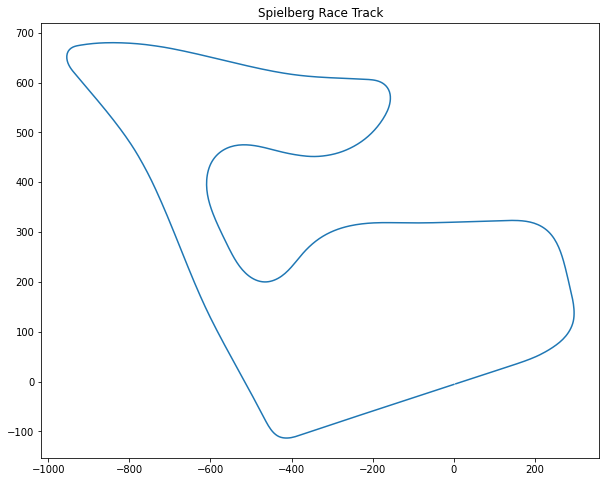

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pyo
from numpy import genfromtxt
import pandas as pd
import matplotlib.pyplot as plt

# #Austria Centerline
# url = 'https://raw.githubusercontent.com/TUMFTM/racetrack-database/master/tracks/Spielberg.csv'

# # Austria Raceline
url = 'https://raw.githubusercontent.com/TUMFTM/racetrack-database/master/racelines/Spielberg.csv'

# # Austin Raceline
# url = 'https://raw.githubusercontent.com/TUMFTM/racetrack-database/master/racelines/Austin.csv'

# # Monza Raceline
# url = 'https://raw.githubusercontent.com/TUMFTM/racetrack-database/master/racelines/Monza.csv'

# # Silverstone Raceline
# url = 'https://raw.githubusercontent.com/TUMFTM/racetrack-database/master/racelines/Silverstone.csv'

# # Suzuka Raceline
# url = 'https://raw.githubusercontent.com/TUMFTM/racetrack-database/master/racelines/Suzuka.csv'

# Spa Raceline
# url = 'https://raw.githubusercontent.com/TUMFTM/racetrack-database/master/racelines/Spa.csv'


data_pd = pd.read_csv(url)
data = data_pd.to_numpy()

# print(data)
fig=plt.figure(figsize=(10,8))
plt.plot(data[:,0],data[:,1])
plt.title('Spielberg Race Track')

x_center = data[:,0]
y_center = data[:,1]
# w_left = data[:,2]
# w_right = data[:,3]

In [3]:
# Find distance of each point on Centerline from start
N_track = len(data)
S_track = np.zeros(N_track)
for i in range(N_track-1):
  S_track[i+1] = S_track[i] + np.linalg.norm([x_center[i+1]-x_center[i],y_center[i+1]-y_center[i]])
# plt.plot(S_track)
print(S_track[-1])


Track_length = S_track[-1]
Track_length = np.round(Track_length,1)
print(np.round(Track_length,1))

4279.754733496924
4279.8


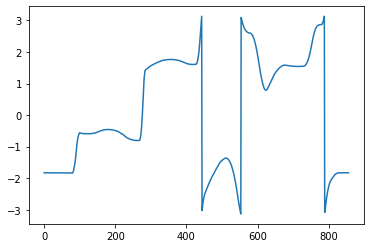

In [4]:
# Find slope of each point on Centerline from start
slope_centerline = np.zeros(N_track)
for i in range(N_track-1):
  slope_centerline[i+1] = np.arctan2(x_center[i+1]-x_center[i],y_center[i+1]-y_center[i])
slope_centerline[0] = np.arctan2(x_center[0]-x_center[N_track-1],y_center[0]-y_center[N_track-1])
plt.plot(slope_centerline)

(0.0, 10000.0)

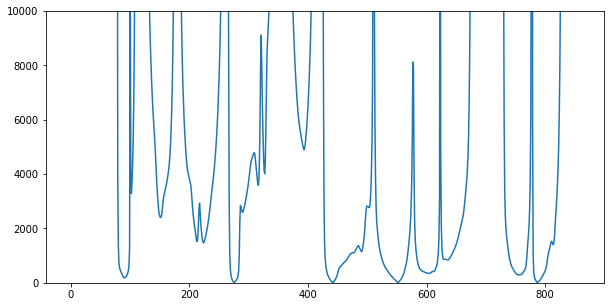

In [5]:
# Find radius of curvature

dx_dt = np.gradient(data[:, 0])
dy_dt = np.gradient(data[:, 1])
velocity = np.array([ [dx_dt[i], dy_dt[i]] for i in range(dx_dt.size)])
ds_dt = np.sqrt(dx_dt * dx_dt + dy_dt * dy_dt)

d2s_dt2 = np.gradient(ds_dt)
d2x_dt2 = np.gradient(dx_dt)
d2y_dt2 = np.gradient(dy_dt)

curvature = np.abs(d2x_dt2 * dy_dt - dx_dt * d2y_dt2) / (dx_dt * dx_dt + dy_dt * dy_dt)**1.5

N_p = len(data)
R_curv = np.zeros(len(data))
for i in range(N_p-1):
  dist = np.linalg.norm(data[i,0:1]-data[i+1,0:1])
  R_curv[i] = dist/curvature[i]
dist = np.linalg.norm(data[N_p-1,0:1]-data[0,0:1])
R_curv[N_p-1] = dist/curvature[N_p-1]

fig=plt.figure(figsize=(10,5))
plt.plot(R_curv)
plt.ylim([0,10000])

16.4747173940493


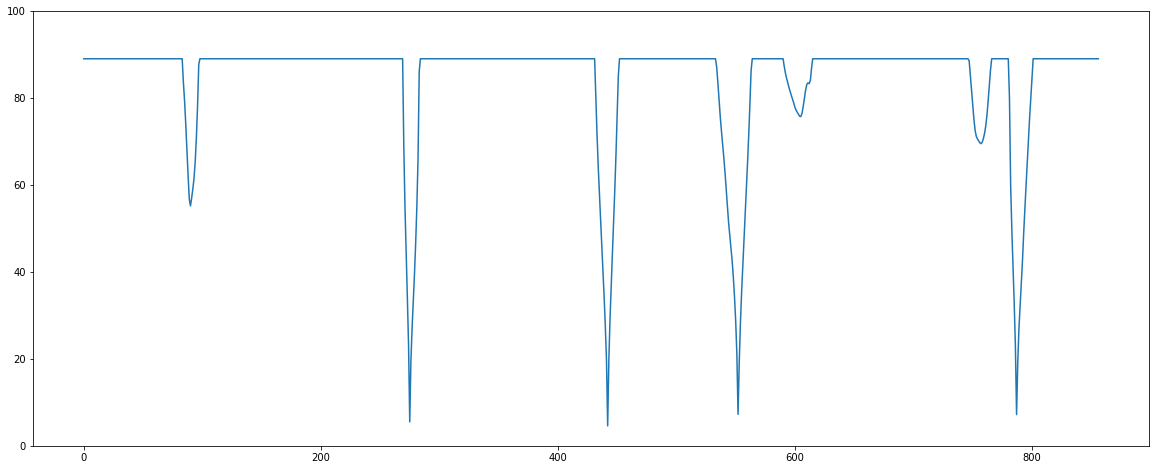

In [6]:
# Get max velocities

mu = 1.7
g = 9.8
car_max_vel = 89

V_max = np.sqrt(mu*R_curv*g)
for i in range(len(V_max)):
  if V_max[i]>car_max_vel:
    V_max[i] = car_max_vel

fig=plt.figure(figsize=(20,8))
plt.plot(V_max)
plt.ylim([0,100])
print(min(V_max)*18/5)

In [7]:
# Functions to get x and y from s

from scipy.interpolate import interp1d

get_x_from_S = interp1d(S_track, x_center)
get_y_from_S = interp1d(S_track, y_center)
get_R_from_S = interp1d(S_track, R_curv)
get_psi_from_S = interp1d(S_track, slope_centerline)
get_Vmax_from_S = interp1d(S_track, V_max)
# get_WL_from_S = interp1d(S_track, w_left)
# get_WR_from_S = interp1d(S_track, w_right)

print(get_x_from_S(10))
print(get_y_from_S(10))
print(get_psi_from_S(10))

-9.591508843468695
-8.30457988211811
-1.8305760394313808


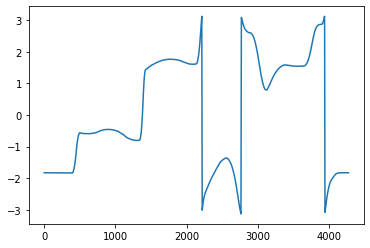

In [8]:
s_check = np.linspace(0,int(np.floor(Track_length))-3,int(np.floor(Track_length))-3)
check = get_psi_from_S(s_check)
plt.plot(check)

**Define Car Parameters**

In [9]:
l_r   = 2.2188
l_f   = 1.4792
C1 = l_r/(l_r+l_f)
C2 = 1/(l_r+l_f)

Ds = 0.1

In [10]:
def revert_states(e_y,s):
    x_tr = get_x_from_S(s)
    y_tr = get_y_from_S(s)
    psi_tr = get_psi_from_S(s)
    x_sol = x_tr - e_y*np.sin(psi_tr)
    y_sol = y_tr - e_y*np.cos(psi_tr)
    return x_sol,y_sol

# Create Non linear Optimization function using Pyomo toolbax and Run MPC

**Create Optimization function**

In [11]:
def solve_cftoc(P, Q, R, N, x0, i, sdot = 1):
  # 

  # States are e_y, e_psi, v, t
  # inputs are a, delta
  # fucntion parameters are R, s_dot

  # Finite constrained optimiation problem


  udotlim = 0.03

  # States are S,w,v,psi
  nx = 4         # number of states
  # Inputs are a, delta
  nu = 2         # number of inputs


  Ds = 1
  # s_dot = 75

  model = pyo.ConcreteModel()
  model.N = N
  model.nx = nx
  model.nu = nu
  model.sidx = pyo.Set(initialize=range(0, N+1)) # length of finite optimization problem
  model.xidx = pyo.Set(initialize=range(0, nx))
  model.uidx = pyo.Set(initialize=range(0, nu))

  # Create state and input variables trajectory:
  model.x = pyo.Var(model.xidx, model.sidx)
  model.u = pyo.Var(model.uidx, model.sidx)




  model.Q = Q
  model.P = P
  model.R = R

  def objective_rule(model):
      costX = 0.0
      costU = 0.0
      costTerminal = 0.0
      for t in model.sidx:
          for i in model.xidx:
              for j in model.xidx:
                  if t < model.N:
                      costX += model.x[i, t] * model.Q[i, j] * model.x[j, t] 
      for t in model.sidx:
          for i in model.uidx:
              for j in model.uidx:
                  if t < model.N:
                      costU += model.u[i, t] * model.R[i, j] * model.u[j, t]
      for i in model.xidx:
          for j in model.xidx:               
              costTerminal += model.x[i, model.N] * model.P[i, j] * model.x[j, model.N]
      return costX + costU + costTerminal

  model.cost = pyo.Objective(rule = objective_rule, sense = pyo.minimize)


  # Constraints:


  # Initial states
  model.constraint1 = pyo.Constraint(model.xidx, rule=lambda model,i : model.x[i, 0] == x0[i])

  # Initial inputs
  model.constraint2 = pyo.Constraint(model.uidx, rule=lambda model,i : model.u[i, 0] == 0.0 )

  # Model
  model.constraint3 = pyo.Constraint(model.sidx, rule=lambda model, s: model.x[0, s+1] == model.x[0, s] + Ds*(model.x[2, s]*pyo.sin(model.x[1, s]) + model.x[2, s]*C1*model.u[1, s]*pyo.cos(model.x[1, s]))/s_dot
                                    if s < N else pyo.Constraint.Skip)
  model.constraint4 = pyo.Constraint(model.sidx, rule=lambda model, s: model.x[1, s+1] == model.x[1, s] + Ds*(model.x[2, s]*model.u[1, s]*C2/s_dot - 1/get_R_from_S((i+s)*Ds))
                                    if s < N else pyo.Constraint.Skip)
  model.constraint5 = pyo.Constraint(model.sidx, rule=lambda model, s: model.x[2, s+1] == model.x[2, s] + Ds*(model.u[0, s]/s_dot) # Ds*((model.u[0, s]-0.5*1.225*(model.x[2, s]*s_dot)**2*1*0.1/736)/s_dot)
                                    if s < N else pyo.Constraint.Skip)
  model.constraint6 = pyo.Constraint(model.sidx, rule=lambda model, s: model.x[3, s+1] == model.x[3, s] + Ds*(1/s_dot)
                                    if s < N else pyo.Constraint.Skip)



  model.constraint7 = pyo.Constraint(model.sidx, rule=lambda model, s: model.x[0, s+1] >= -2 # -get_WL_from_S((i+s)*Ds) #eqns
                                    if s < N else pyo.Constraint.Skip)
  model.constraint8 = pyo.Constraint(model.sidx, rule=lambda model, s: model.x[0, s+1] <= 2 #get_WR_from_S((i+s)*Ds) #eqns
                                    if s < N else pyo.Constraint.Skip)

  # Car constraints
  model.constraint9 = pyo.Constraint(model.sidx, rule=lambda model, s: model.x[2, s] <= 89 #get_Vmax_from_S((i+s)*Ds)
                                    if s < N else pyo.Constraint.Skip)

  # Input Constraints
  model.constraint10 = pyo.Constraint(model.sidx, rule=lambda model, s: model.u[0, s+1] <= 10.68
                                    if s < N-1 else pyo.Constraint.Skip)
  model.constraint11 = pyo.Constraint(model.sidx, rule=lambda model, s: model.u[0, s+1] >= -49.05
                                    if s < N-1 else pyo.Constraint.Skip)
  model.constraint12 = pyo.Constraint(model.sidx, rule=lambda model, s: model.u[1, s+1] <= 30/180*np.pi
                                    if s < N-1 else pyo.Constraint.Skip)
  model.constraint13 = pyo.Constraint(model.sidx, rule=lambda model, s: model.u[1, s+1] >= -30/180*np.pi
                                    if s < N-1 else pyo.Constraint.Skip)


  # Now we can solve:
  solver = pyo.SolverFactory('ipopt')
  results = solver.solve(model)
  # results = pyo.SolverFactory('ipopt').solve(model).write()

  if str(results.solver.termination_condition) == "optimal":
      feas = True
  else:
      feas = False
  xOpt = np.asarray([[model.x[i,s]() for i in model.xidx] for s in model.sidx]).T  ###########
  uOpt = np.asarray([model.u[:,s]() for s in model.sidx]).T
  JOpt = model.cost()
  # model.display()
      
  return [feas, xOpt, uOpt, JOpt]
      


(-1016.7077531071817,
 358.94469075387605,
 -153.0200991217404,
 719.6641669508987)

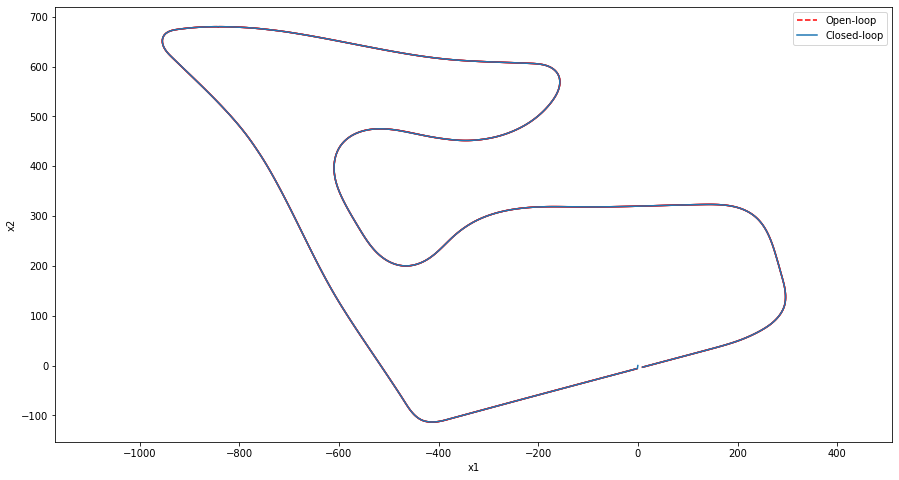

In [12]:
N = 3

x0 = np.array([0,0,0,0])

# Objective:
# Trajectory Tracking
# Q = np.diag([1,0.01,0.1,0])
# R = np.diag([1e-4,1e-4])
# P = Q

# Time optimal Formulation
Q = np.diag([5e-4,1e-10,1e-10,1e-10])
R = np.diag([1e-3,1e-10])
P = np.diag([1e-10*0,1e-10,1e-10,1])



nx = 4
nu = 2

Ds = 1
M = int(Track_length/Ds) - N - 1#25   # Simulation time

xOpt = np.zeros((nx, M+1))
xOpt_XY = np.zeros((2, M+1))
uOpt = np.zeros((nu, M))
xOpt[:, 0] = x0.reshape(nx, )

xPred = np.zeros((nx, N+1, M))

feas = np.zeros((M, ), dtype=bool)

fig = plt.figure(figsize=(15, 8))
for i in range(M):
    s_dot = get_Vmax_from_S(i*Ds)
    [feas[i], x, u, J] = solve_cftoc(P, Q, R, N, xOpt[:, i],i, s_dot)
    
    if not feas[i]:
        xOpt = []
        uOpt = []
        predErr = []
        break
    # Save open loop predictions
    xPred[:, :, i] = x

    # Save closed loop trajectory
    # Note that the second column of x represents the optimal closed loop state
    xOpt[:, i+1] = x[:, 1]
    xOpt_XY[:,i+1] = revert_states(xOpt[0, i+1],(i+1)*Ds)
    x_XY = np.zeros((2, N+1))
    x_XY[:,0] = revert_states(x[0, 0],(i)*Ds)
    for j in range(N):
      x_XY[:,j+1] = revert_states(x[0, j+1],(i+j+1)*Ds)
      
    uOpt[:, i] = u[:, 0].reshape(nu, )

    # Plot Open Loop
    line1 = plt.plot(x_XY[0,:], x_XY[1,:], 'r--')

# Plot Closed Loop
line2 = plt.plot(xOpt_XY[0, :], xOpt_XY[1, :])#, 'bo-')
plt.legend([line1[0], line2[0]], ['Open-loop', 'Closed-loop']);
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')


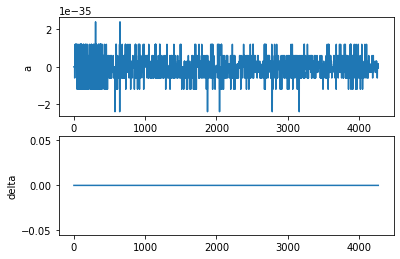

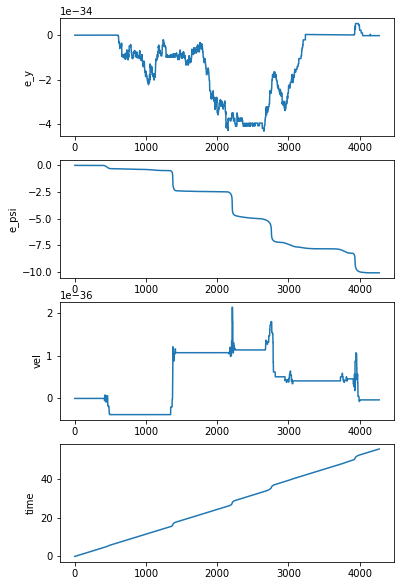

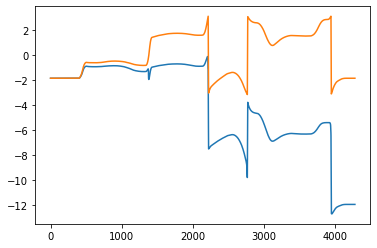

In [13]:
# plot results
e_y = xOpt[0,:]
e_psi = xOpt[1,:]
vel = xOpt[2,:]
time = xOpt[3,:]
acc = uOpt[0,:]
delta = uOpt[1,:]


plt.figure()
plt.subplot(2,1,1)
plt.plot(acc)
plt.ylabel('a')
plt.subplot(2,1,2)
plt.plot(delta)
plt.ylabel('delta')

plt.figure(figsize= (6,10))
plt.subplot(4,1,1)
plt.plot(e_y)
plt.ylabel('e_y')
plt.subplot(4,1,2)
plt.plot(e_psi)
plt.ylabel('e_psi')
plt.subplot(4,1,3)
plt.plot(vel)
plt.ylabel('vel')
plt.subplot(4,1,4)
plt.plot(time)
plt.ylabel('time')
plt.show()

plt.figure()
plt.plot(e_psi+check)
plt.plot(check)

**Time taken to complete 1 Lap =**

In [14]:
print(time[-1])

55.512298329310006
